# Neural _Networks_Classification

## Binary_Classification with torch Model_0

### 1.1 Get Out Toy dataset classification

In [1]:
# Get toy dataset
from sklearn.datasets import make_circles

# make n_samples
N_SAMPLES = 1000
RANDOM_SEED=42

# make dataset
X, y = make_circles(n_samples=N_SAMPLES,
                    noise=0.03,
                    random_state=RANDOM_SEED)

In [2]:
# check on data
len(X), len(y)

(1000, 1000)

In [3]:
print(f"One Sample of X : {X[0]} with shape : {X[0].shape} | Shape of x is : {X.shape}")
print(f"One Sample of y : {y[0]} with shape : {y[0].shape} | Shape of x is : {y.shape}")

One Sample of X : [0.75424625 0.23148074] with shape : (2,) | Shape of x is : (1000, 2)
One Sample of y : 1 with shape : () | Shape of x is : (1000,)


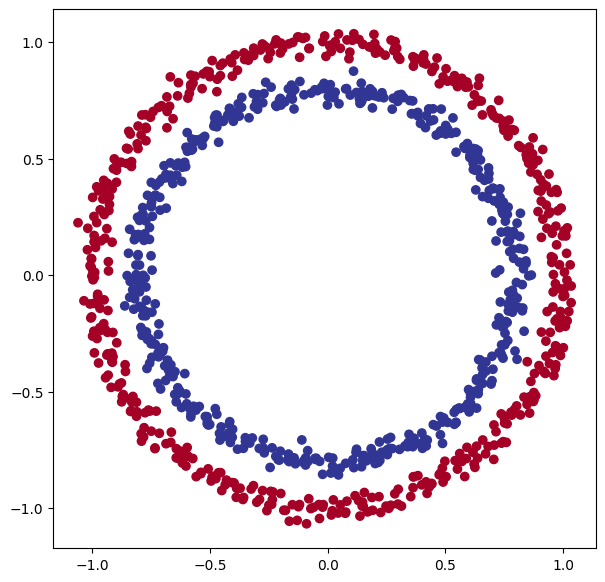

In [4]:
# Visualize Our Data
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.2 Turning data into tensors

In [5]:
import torch

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
from sklearn.model_selection import train_test_split

# splitting data into test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2.1 Setup device agnostic code

In [7]:
# setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# check on in, out data
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

### 2.2 Create small NN class For our data

In [9]:
import torch
from torch import nn

# creating our model
class CircleModelV0(nn.Module):
  def __init__(self, in_features:int, out_features:int, hidden_units:int):
    super().__init__()

    # Create NN layers
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  # create forward fn
  def forward(self, X:torch.tensor) :
    return self.layer_stack(X)

In [10]:
# instantiate instance from model
model_0 = CircleModelV0(in_features=2,
                        out_features=1,
                        hidden_units=10).to(device)

model_0

CircleModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [11]:
# check on device
next(model_0.parameters()).device

device(type='cuda', index=0)

### 2.3 Create loss, optimizer and Evaluation metric for model_0

In [12]:
# create loss_fn
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

# Calculate accuracy (a classification metric)
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### Going out from model logits into preds

In [13]:
X_test.dtype

torch.float32

In [14]:
# pred with logits
model_0.eval()
with torch.inference_mode():
  X_test = X_test.to(device)
  y_logits = model_0(X_test)

# convert logits into pred_prob
y_pred_prob = torch.sigmoid(y_logits)
# convert it into laabels
y_pred_labels = torch.round(y_pred_prob)

y_logits[:5], y_pred_prob[:5], y_pred_labels[:5], y_test[:5]

(tensor([[0.5764],
         [0.6040],
         [0.3196],
         [0.6500],
         [0.0264]], device='cuda:0'),
 tensor([[0.6402],
         [0.6466],
         [0.5792],
         [0.6570],
         [0.5066]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [15]:
# pred without logits
model_0.eval()
with torch.inference_mode():
  X_test = X_test.to(device)
  y_logits = model_0(X_test)
y_logits[:5], torch.round(y_logits[:5]), y_test[:5]

(tensor([[0.5764],
         [0.6040],
         [0.3196],
         [0.6500],
         [0.0264]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

### 3.1 Coding train, test loops

In [16]:
# Coding train, test loops
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# put data on Gpu devcies
X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

# Nums of Epochs
epochs = 100

# Create loops tarin, test
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. forward pass
  train_pred_logits = model_0(X_train).squeeze()
  train_pred_labels = torch.round(torch.sigmoid(train_pred_logits))


  # 2. calc loss_fn, acc_fn
  train_loss = loss_fn(train_pred_logits, y_train)
  train_acc  = acc_fn(y_true=y_train, y_pred=train_pred_labels)

  # 3. optmize zero_grad
  optimizer.zero_grad()

  # 4. loss_backward
  train_loss.backward()

  # 5. optmizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():

    # 1. forward pass
    test_pred_logits = model_0(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

    # 2. calc loss_fn, acc_fn
    test_loss = loss_fn(test_pred_logits, y_test)
    test_acc  = acc_fn(y_true=y_test, y_pred=test_pred_labels)

  # Print what's hapnin' !!
  if epoch % 10 == 0 :
    print(f"Epoch : {epoch} | Train_loss : {train_loss:.5f}, Train_Acc : {train_acc:.2f} | Test_loss : {test_loss:.5f}, Test_Acc : {test_acc:.2f}%")


Epoch : 0 | Train_loss : 0.70948, Train_Acc : 56.62 | Test_loss : 0.71685, Test_Acc : 54.50%
Epoch : 10 | Train_loss : 0.70759, Train_Acc : 57.75 | Test_loss : 0.71462, Test_Acc : 55.00%
Epoch : 20 | Train_loss : 0.70592, Train_Acc : 59.13 | Test_loss : 0.71263, Test_Acc : 55.50%
Epoch : 30 | Train_loss : 0.70445, Train_Acc : 59.75 | Test_loss : 0.71087, Test_Acc : 57.00%
Epoch : 40 | Train_loss : 0.70315, Train_Acc : 59.50 | Test_loss : 0.70930, Test_Acc : 57.00%
Epoch : 50 | Train_loss : 0.70200, Train_Acc : 57.63 | Test_loss : 0.70790, Test_Acc : 54.00%
Epoch : 60 | Train_loss : 0.70099, Train_Acc : 56.25 | Test_loss : 0.70666, Test_Acc : 53.50%
Epoch : 70 | Train_loss : 0.70010, Train_Acc : 55.38 | Test_loss : 0.70555, Test_Acc : 54.50%
Epoch : 80 | Train_loss : 0.69932, Train_Acc : 54.87 | Test_loss : 0.70455, Test_Acc : 54.00%
Epoch : 90 | Train_loss : 0.69862, Train_Acc : 54.62 | Test_loss : 0.70367, Test_Acc : 54.50%


### 3.2 Imoprt Helper functions python file

In [17]:
import requests
from pathlib import Path

try:
  print(f"Downloading helper_functions.py")

  request = requests.get('https://raw.githubusercontent.com/es-OmarHani/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f :
    f.write(request.content)

except:
  print(f"helper_functions.py is already exist")

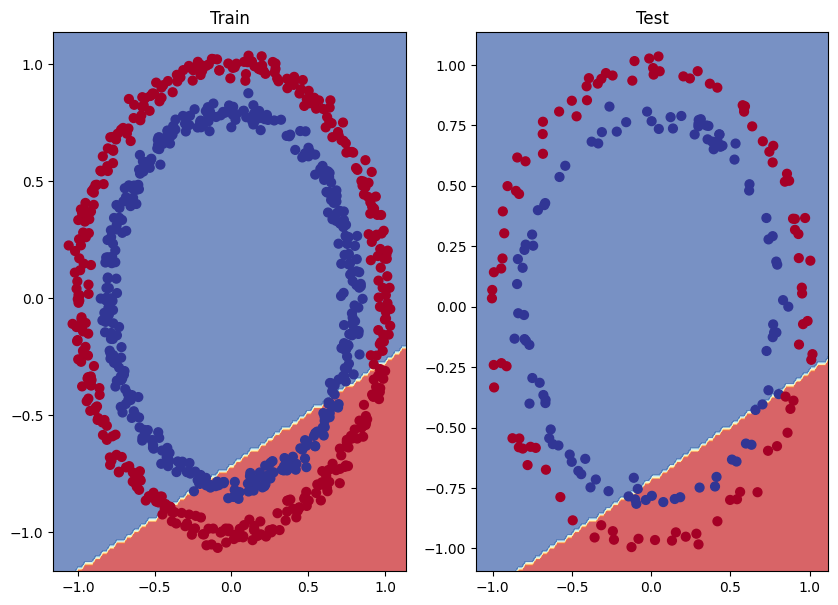

In [18]:
# let's visualize our Decision Boundry
from helper_functions import plot_decision_boundary

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## Binary_Classification with torch Model_1


### Craeting NN Model

In [19]:
import torch
from torch import nn

# creating our model
class CircleModelV1(nn.Module):
  def __init__(self, in_features:int, out_features:int, hidden_units:int):
    super().__init__()

    # Create NN layers
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  # create forward fn
  def forward(self, X:torch.tensor) :
    return self.layer_stack(X)

In [20]:
# instantiate instance from model
model_1 = CircleModelV1(in_features=2,
                        out_features=1,
                        hidden_units=10).to(device)

model_1

CircleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [21]:
# check on device
next(model_1.parameters()).device

device(type='cuda', index=0)

### Create loss, optimizer

In [22]:
# create loss_fn
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

# Calculate accuracy (a classification metric)
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### Coding train, test loops

In [23]:
# Coding train, test loops
torch.manual_seed(42)

# put data on Gpu devcies
X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

# Nums of Epochs
epochs = 1000

# Create loops tarin, test
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. forward pass
  train_pred_logits = model_1(X_train).squeeze()
  train_pred_labels = torch.round(torch.sigmoid(train_pred_logits))


  # 2. calc loss_fn, acc_fn
  train_loss = loss_fn(train_pred_logits, y_train)
  train_acc  = acc_fn(y_true=y_train, y_pred=train_pred_labels)

  # 3. optmize zero_grad
  optimizer.zero_grad()

  # 4. loss_backward
  train_loss.backward()

  # 5. optmizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():

    # 1. forward pass
    test_pred_logits = model_1(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

    # 2. calc loss_fn, acc_fn
    test_loss = loss_fn(test_pred_logits, y_test)
    test_acc  = acc_fn(y_true=y_test, y_pred=test_pred_labels)

  # Print what's hapnin' !!
  if epoch % 100 == 0 :
    print(f"Epoch : {epoch} | Train_loss : {train_loss:.2f}, Train_Acc : {train_acc:.3f}% | Test_loss : {test_loss:.5f}, Test_Acc : {test_acc:.2f}%")


Epoch : 0 | Train_loss : 0.69, Train_Acc : 50.000% | Test_loss : 0.69319, Test_Acc : 50.00%
Epoch : 100 | Train_loss : 0.69, Train_Acc : 52.875% | Test_loss : 0.69102, Test_Acc : 52.50%
Epoch : 200 | Train_loss : 0.69, Train_Acc : 53.375% | Test_loss : 0.68940, Test_Acc : 55.00%
Epoch : 300 | Train_loss : 0.69, Train_Acc : 53.000% | Test_loss : 0.68723, Test_Acc : 56.00%
Epoch : 400 | Train_loss : 0.69, Train_Acc : 52.750% | Test_loss : 0.68411, Test_Acc : 56.50%
Epoch : 500 | Train_loss : 0.68, Train_Acc : 52.750% | Test_loss : 0.67941, Test_Acc : 56.50%
Epoch : 600 | Train_loss : 0.68, Train_Acc : 54.500% | Test_loss : 0.67285, Test_Acc : 56.00%
Epoch : 700 | Train_loss : 0.67, Train_Acc : 58.375% | Test_loss : 0.66322, Test_Acc : 59.00%
Epoch : 800 | Train_loss : 0.65, Train_Acc : 64.000% | Test_loss : 0.64757, Test_Acc : 67.50%
Epoch : 900 | Train_loss : 0.62, Train_Acc : 74.000% | Test_loss : 0.62145, Test_Acc : 79.00%


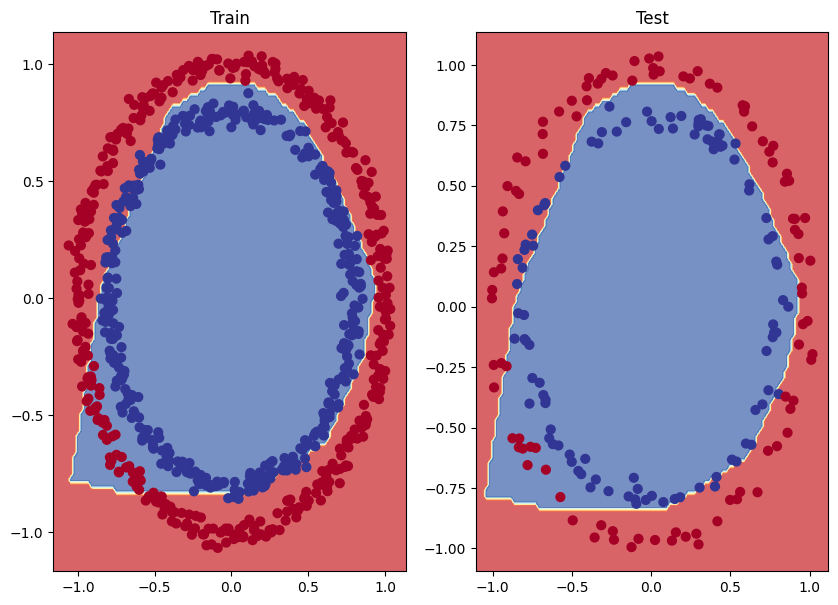

In [24]:
# let's visualize our Decision Boundry
from helper_functions import plot_decision_boundary

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

## Multi_class Classification Model_1

### 1.1 Get Out Toy dataset classification

### 2.1 Setup device agnostic code

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1]) torch.int64


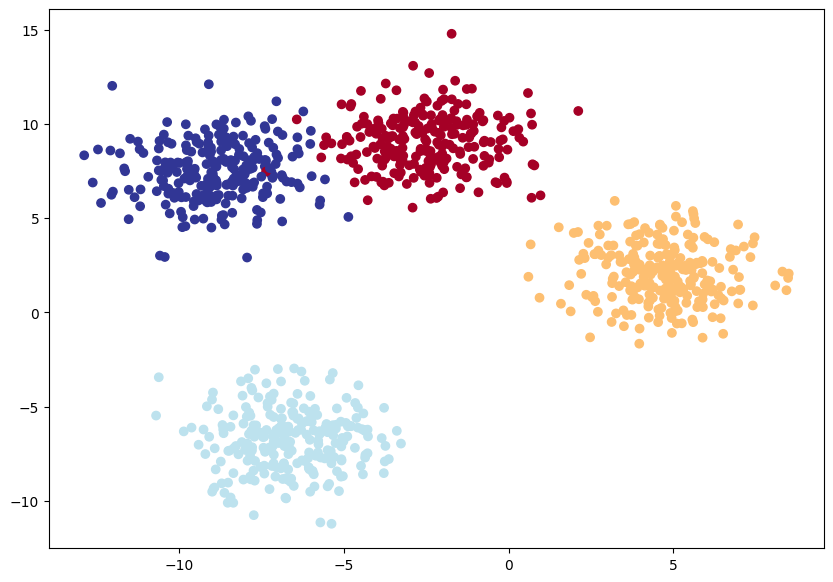

In [37]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5], y_blob.dtype)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [38]:
y_blob_train.dtype , y_blob_test.dtype, X_blob_train.dtype

(torch.int64, torch.int64, torch.float32)

In [39]:
# setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 2.2 Create small NN class For our data

In [40]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 2.3 Create loss, optimizer and Evaluation metric for model_3

In [41]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### Going out from model logits into preds

In [42]:
# pred with logits
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_test.to(device))

# convert logits into pred_prob
y_pred_prob = torch.softmax(y_logits, dim=1)
# convert it into laabels
y_pred_labels = torch.argmax(y_pred_prob, dim=1)

y_logits[:5], y_pred_prob[:5], y_pred_prob.shape, y_pred_labels[:5], y_test[:5]

(tensor([[ 0.2341, -0.3357,  0.2307,  0.2534],
         [ 0.1198, -0.3702,  0.0998,  0.1887],
         [ 0.3790, -0.2037,  0.4095,  0.2689],
         [ 0.1936, -0.3733,  0.1807,  0.2496],
         [ 0.1338, -0.1378,  0.1487,  0.0247]], device='cuda:0'),
 tensor([[0.2792, 0.1579, 0.2782, 0.2846],
         [0.2729, 0.1672, 0.2675, 0.2924],
         [0.2869, 0.1602, 0.2958, 0.2570],
         [0.2769, 0.1571, 0.2733, 0.2928],
         [0.2722, 0.2075, 0.2763, 0.2441]], device='cuda:0'),
 torch.Size([200, 4]),
 tensor([3, 3, 2, 3, 2], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

### 3.1 Coding train, test loops

In [45]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = acc_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = acc_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


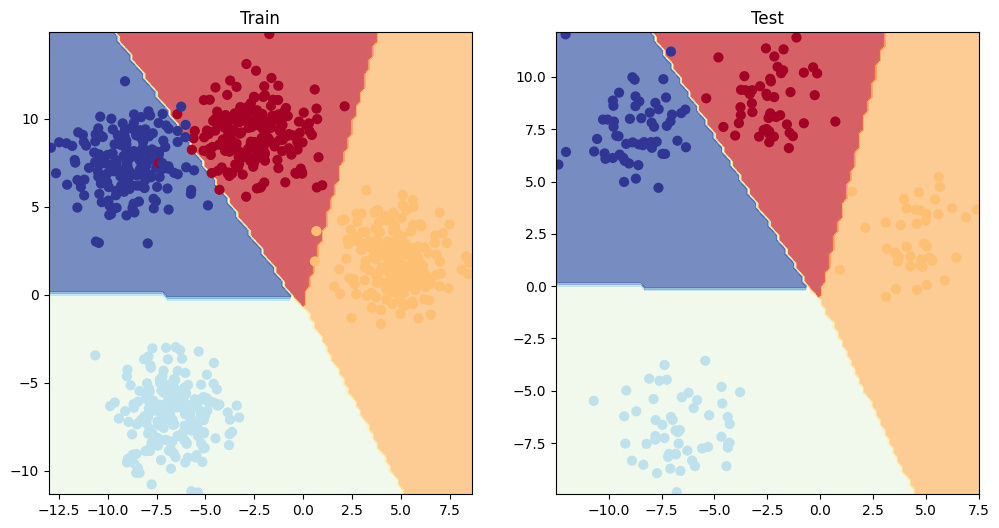

In [47]:
# Visualize Decision Boundry
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)